In [215]:
import numpy as np
import pandas as pd
from collections import Counter


def evaluate_topk_metrics(topk_df, ground_truth_df, k=10, tail_items=None, item_popularity=None, total_item_count=None):
    """
    Evaluate Top-K recommendation metrics using RecBole-consistent implementation.

    Parameters:
    - topk_df: DataFrame with ['user_id', 'gender', 'topk_items']
    - ground_truth_df: DataFrame with ['user_id', 'relevant_items_sorted_by_rating']
    - k: Top-k cutoff
    - tail_items: set of str item_ids considered long-tail
    - item_popularity: dict {item_id (str): popularity (int)} for AveragePopularity
    - total_item_count: int, total number of items (for ItemCoverage)

    Returns:
    - dict: evaluation results, printed and returned
    """

    # === Step 1: Clean and parse input ===
    topk_df['user_id'] = topk_df['user_id'].astype(str)
    topk_df['topk_items'] = topk_df['topk_items'].astype(str)
    topk_df['gender'] = topk_df['gender'].astype(str)
    ground_truth_df['user_id'] = ground_truth_df['user_id'].astype(str)
    ground_truth_df['relevant_items_sorted_by_rating'] = ground_truth_df['relevant_items_sorted_by_rating'].astype(str)

    user2gt = dict(zip(
        ground_truth_df['user_id'],
        ground_truth_df['relevant_items_sorted_by_rating'].apply(lambda x: set(x.split(',')))
    ))
    user2topk = dict(zip(
        topk_df['user_id'],
        topk_df['topk_items'].apply(lambda x: x.split(',')[:k])
    ))
    user2gender = dict(zip(topk_df['user_id'], topk_df['gender']))

    precision_list, recall_list, hit_list, ndcg_list = [], [], [], []
    ndcg_male, ndcg_female = [], []
    recommended_items = []
    avg_pop_list = []
    tail_pct_list = []

    for user, pred in user2topk.items():
        if user not in user2gt:
            continue
        gt_items = user2gt[user]
        hits = [1 if item in gt_items else 0 for item in pred]
        hit_count = sum(hits)

        # Accuracy
        precision = hit_count / k
        recall = hit_count / len(gt_items) if gt_items else 0
        hit = 1.0 if hit_count > 0 else 0.0
        dcg = sum([rel / np.log2(i + 2) for i, rel in enumerate(hits)])
        idcg = sum([1 / np.log2(i + 2) for i in range(min(len(gt_items), k))])
        ndcg = dcg / idcg if idcg > 0 else 0

        precision_list.append(precision)
        recall_list.append(recall)
        hit_list.append(hit)
        ndcg_list.append(ndcg)

        if user2gender[user] == 'M':
            ndcg_male.append(ndcg)
        elif user2gender[user] == 'F':
            ndcg_female.append(ndcg)

        # Diversity / Popularity
        recommended_items.extend(pred)
        avg_pop = np.mean([item_popularity.get(item, 0) for item in pred])
        avg_pop_list.append(avg_pop)

        tail_pct = np.mean([1 if item in tail_items else 0 for item in pred])
        tail_pct_list.append(tail_pct)

    # === Diversity Metrics ===
    item_counts = Counter(recommended_items)
    item_freqs = np.array(list(item_counts.values()))
    total_recs = len(user2topk) * k
    p_i = item_freqs / total_recs

    # Shannon Entropy (normalized)
    if len(p_i) > 1:
        shannon = -np.sum(p_i * np.log2(p_i)) / np.log2(len(p_i))
    else:
        shannon = 0

    # Gini Index (RecBole version)
    sorted_counts = np.sort(item_freqs)
    n = len(sorted_counts)
    idx = np.arange(1, n + 1)
    gini = np.sum((2 * idx - n - 1) * sorted_counts) / (n * np.sum(sorted_counts))

    # Item Coverage
    item_cov = len(item_counts) / total_item_count

    # === Final Output ===
    results = {
        f"Total users evaluated": len(ndcg_list),
        f"Precision@{k}": np.mean(precision_list),
        f"Recall@{k}": np.mean(recall_list),
        f"Hit@{k}": np.mean(hit_list),
        f"NDCG@{k} (all)": np.mean(ndcg_list),
        f"NDCG@{k} (male)": np.mean(ndcg_male) if ndcg_male else float('nan'),
        f"NDCG@{k} (female)": np.mean(ndcg_female) if ndcg_female else float('nan'),
        f"ItemCoverage@{k}": item_cov,
        f"AveragePopularity@{k}": np.mean(avg_pop_list),
        f"ShannonEntropy@{k}": shannon,
        f"GiniIndex@{k}": gini,
        f"TailPercentage@{k}": np.mean(tail_pct_list)
    }

    # Print with 4 decimals
    for k, v in results.items():
        print(f"{k:<25}: {v:.4f}" if isinstance(v, float) else f"{k:<25}: {v}")
    return results

In [216]:
ground_truth = pd.read_csv('../rank_results/ml-1m/ml_test_ground_truth_sorted.csv')

In [217]:
# Load training interaction data
train_df = pd.read_csv('../datasets/split_datasets/ml-1m/ml-1m.train.inter', sep='\t')
# Step 1: Count item popularity (interaction frequency)
train_df['item_id:token'] = train_df['item_id:token'].astype(str)
item_popularity = train_df['item_id:token'].value_counts().to_dict()
# Step 2: Sort items by popularity (descending)
item_freq_sorted = sorted(item_popularity.items(), key=lambda x: x[1], reverse=True)
# Step 3: Define long-tail cutoff (e.g., bottom 20%)
tail_ratio = 0.2
cutoff_index = int((1 - tail_ratio) * len(item_freq_sorted))
tail_item_set = set(item for item, _ in item_freq_sorted[cutoff_index:])

total_items = len(item_freq_sorted)
# === Print summary ===
print(f"Total unique items: {len(item_freq_sorted)}")
print(f"Tail defined as bottom {tail_ratio * 100:.0f}% of items")
print(f"Tail threshold frequency (≤): {item_freq_sorted[cutoff_index][1]}")
print(f"Number of long-tail items: {len(tail_item_set)}")

Total unique items: 3683
Tail defined as bottom 20% of items
Tail threshold frequency (≤): 19
Number of long-tail items: 737


In [218]:
topk_df_base = pd.read_csv('../rank_results/ml-1m/ml_top50.csv')
base_result = evaluate_topk_metrics(topk_df_base, ground_truth, k=10, tail_items=tail_item_set,
                                    item_popularity=item_popularity, total_item_count=total_items)

Total users evaluated    : 6012
Precision@10             : 0.0547
Recall@10                : 0.0787
Hit@10                   : 0.4283
NDCG@10 (all)            : 0.0756
NDCG@10 (male)           : 0.0770
NDCG@10 (female)         : 0.0721
ItemCoverage@10          : 0.3758
AveragePopularity@10     : 1299.8182
ShannonEntropy@10        : 0.7930
GiniIndex@10             : 0.7952
TailPercentage@10        : 0.0002


In [219]:
topk_df_resample = pd.read_csv('../rank_results/ml-1m/ml_top10_resample.csv')
resample_result = evaluate_topk_metrics(topk_df_resample, ground_truth, k=10, tail_items=tail_item_set,
                                        item_popularity=item_popularity, total_item_count=total_items)

Total users evaluated    : 6012
Precision@10             : 0.0539
Recall@10                : 0.0716
Hit@10                   : 0.4163
NDCG@10 (all)            : 0.0731
NDCG@10 (male)           : 0.0743
NDCG@10 (female)         : 0.0701
ItemCoverage@10          : 0.3074
AveragePopularity@10     : 1545.8430
ShannonEntropy@10        : 0.7232
GiniIndex@10             : 0.8584
TailPercentage@10        : 0.0005


In [220]:
topk_df_relabel = pd.read_csv('../rank_results/ml-1m/ml_top10_relabel.csv')
relabel_result = evaluate_topk_metrics(topk_df_relabel, ground_truth, k=10, tail_items=tail_item_set,
                                       item_popularity=item_popularity, total_item_count=total_items)

Total users evaluated    : 6012
Precision@10             : 0.0535
Recall@10                : 0.0772
Hit@10                   : 0.4210
NDCG@10 (all)            : 0.0727
NDCG@10 (male)           : 0.0739
NDCG@10 (female)         : 0.0696
ItemCoverage@10          : 0.3986
AveragePopularity@10     : 1276.9728
ShannonEntropy@10        : 0.7976
GiniIndex@10             : 0.7886
TailPercentage@10        : 0.0001


In [221]:
topk_df_fair = pd.read_csv('../rank_results/ml-1m/ml_top10_fair.csv')
fair_result = evaluate_topk_metrics(topk_df_fair, ground_truth, k=10, tail_items=tail_item_set,
                                    item_popularity=item_popularity, total_item_count=total_items)

Total users evaluated    : 6012
Precision@10             : 0.0547
Recall@10                : 0.0787
Hit@10                   : 0.4283
NDCG@10 (all)            : 0.0756
NDCG@10 (male)           : 0.0770
NDCG@10 (female)         : 0.0721
ItemCoverage@10          : 0.3785
AveragePopularity@10     : 1299.7498
ShannonEntropy@10        : 0.7923
GiniIndex@10             : 0.7965
TailPercentage@10        : 0.0005


In [222]:
topk_df_calibrated = pd.read_csv('../rank_results/ml-1m/ml_top10_calibrated.csv')
calibrated_result = evaluate_topk_metrics(topk_df_fair, ground_truth, k=10, tail_items=tail_item_set,
                                          item_popularity=item_popularity, total_item_count=total_items)

Total users evaluated    : 6012
Precision@10             : 0.0547
Recall@10                : 0.0787
Hit@10                   : 0.4283
NDCG@10 (all)            : 0.0756
NDCG@10 (male)           : 0.0770
NDCG@10 (female)         : 0.0721
ItemCoverage@10          : 0.3785
AveragePopularity@10     : 1299.7498
ShannonEntropy@10        : 0.7923
GiniIndex@10             : 0.7965
TailPercentage@10        : 0.0005


In [223]:
topk_df_equity = pd.read_csv('../rank_results/ml-1m/ml_top10_equity.csv')
equity_result = evaluate_topk_metrics(topk_df_equity, ground_truth, k=10, tail_items=tail_item_set,
                                      item_popularity=item_popularity, total_item_count=total_items)

Total users evaluated    : 6012
Precision@10             : 0.0454
Recall@10                : 0.0660
Hit@10                   : 0.3719
NDCG@10 (all)            : 0.0626
NDCG@10 (male)           : 0.0635
NDCG@10 (female)         : 0.0603
ItemCoverage@10          : 0.5778
AveragePopularity@10     : 842.5324
ShannonEntropy@10        : 0.8975
GiniIndex@10             : 0.6302
TailPercentage@10        : 0.0006


In [224]:
import pandas as pd

# === Step 1: Organize Results ===
results_dict = {
    "Base": base_result,
    "Resample": resample_result,
    "Relabel": relabel_result,
    "FA*IR": fair_result,
    "Calibrated": calibrated_result,
    "Equity": equity_result
}

# === Step 2: Rename Columns for Publication ===
column_rename_map = {
    "Precision@10": "Pre@10",
    "Recall@10": "Rec@10",
    "Hit@10": "Hit@10",
    "NDCG@10 (all)": "NDCG@10",
    "NDCG@10 (male)": "NDCG@10(M)",
    "NDCG@10 (female)": "NDCG@10(F)",
    "ItemCoverage@10": "IC@10",
    "AveragePopularity@10": "AP@10",
    "ShannonEntropy@10": "SE@10",
    "GiniIndex@10": "GI@10",
    "TailPercentage@10": "TP@10"
}

# === Step 3: Build and Clean the DataFrame ===
df_results = pd.DataFrame(results_dict).T  # methods as rows
df_results = df_results.round(4)  # round all values to 4 decimals
df_results.drop(columns=["Total users evaluated"], errors='ignore', inplace=True)  # optional cleanup
df_results.rename(columns=column_rename_map, inplace=True)

# Add method name as a column for display/export
df_results.index.name = "Method"
df_results.reset_index(inplace=True)

In [225]:
import pandas as pd


def display_styled_results(df: pd.DataFrame):
    # Define metric groups
    accuracy_cols = ['Pre@10', 'Rec@10', 'Hit@10', 'NDCG@10', 'NDCG@10(M)', 'NDCG@10(F)']
    diversity_cols = ['IC@10', 'AP@10', 'SE@10', 'GI@10', 'TP@10']

    styled = (
        df.style
        .set_caption("Top-K Evaluation Metrics Across Fairness Methods for ML-1M Dataset")
        .format("{:.4f}", subset=accuracy_cols + diversity_cols)
        .background_gradient(cmap='Greens', subset=accuracy_cols, axis=None)
        .background_gradient(cmap='Purples', subset=diversity_cols, axis=None)
        .set_table_styles([
            # Force white background
            {"selector": " ", "props": [("background-color", "#ffffff"), ("color", "#000000")]},
            {"selector": "caption",
             "props": [("caption-side", "top"), ("font-size", "14pt"), ("font-weight", "bold"), ("color", "#333")]},
            {"selector": "th",
             "props": [("font-size", "11pt"), ("font-weight", "bold"), ("background-color", "#f7f7f7"),
                       ("color", "#000000"), ("text-align", "center")]},
            {"selector": "td", "props": [("font-size", "10pt"), ("background-color", "#ffffff"), ("color", "#000000"),
                                         ("text-align", "center")]},
            {"selector": "tr:nth-child(even)", "props": [("background-color", "#fafafa")]}
        ], overwrite=True)
        .hide(axis="index")
    )
    return styled


# Call
display(display_styled_results(df_results))

Method,Pre@10,Rec@10,Hit@10,NDCG@10,NDCG@10(M),NDCG@10(F),IC@10,AP@10,SE@10,GI@10,TP@10
Base,0.0547,0.0787,0.4283,0.0756,0.0770,0.0721,0.3758,1299.8182,0.7930,0.7952,0.0002
Resample,0.0539,0.0716,0.4163,0.0731,0.0743,0.0701,0.3074,1545.8430,0.7232,0.8584,0.0005
Relabel,0.0535,0.0772,0.4210,0.0727,0.0739,0.0696,0.3986,1276.9728,0.7976,0.7886,0.0001
FA*IR,0.0547,0.0787,0.4283,0.0756,0.0770,0.0721,0.3785,1299.7498,0.7923,0.7965,0.0005
Calibrated,0.0547,0.0787,0.4283,0.0756,0.0770,0.0721,0.3785,1299.7498,0.7923,0.7965,0.0005
Equity,0.0454,0.0660,0.3719,0.0626,0.0635,0.0603,0.5778,842.5324,0.8975,0.6302,0.0006


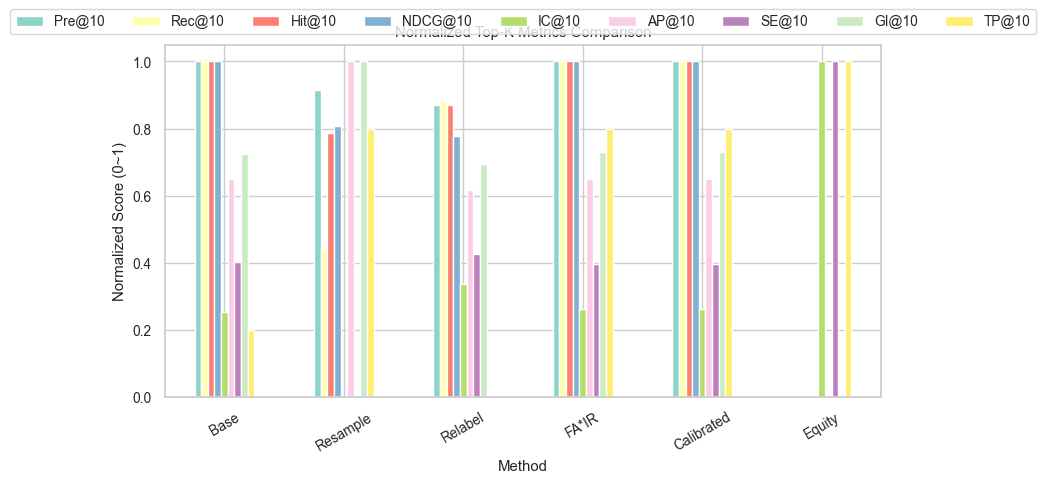

In [226]:
import matplotlib.pyplot as plt

metrics_to_plot = ['Pre@10', 'Rec@10', 'Hit@10', 'NDCG@10', 'IC@10', 'AP@10', 'SE@10', 'GI@10', 'TP@10']
acc_metrics = ['Pre@10', 'Hit@10','Rec@10', 'NDCG@10']
fair_metrics = ['IC@10', 'AP@10', 'SE@10', 'GI@10', 'TP@10']
df_plot = df_results.set_index("Method")[metrics_to_plot]
from sklearn.preprocessing import MinMaxScaler

# 保留原始数据
df_scaled = df_plot.copy()
scaler = MinMaxScaler()
df_scaled[df_scaled.columns] = scaler.fit_transform(df_scaled)

df_scaled.plot(kind='bar', figsize=(10, 5), colormap='Set3')
plt.title("Normalized Top-K Metrics Comparison")
plt.ylabel("Normalized Score (0~1)")
plt.xticks(rotation=30)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.12), ncol=len(metrics_to_plot))
plt.tight_layout()
plt.show()

In [227]:
def plot_metrics_row(df, metrics, ncols=None):
    sns.set(style="whitegrid", font_scale=0.9)
    
    n_metrics = len(metrics)
    if ncols is None:
        ncols = n_metrics
    nrows = (n_metrics + ncols - 1) // ncols
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3 * ncols, 5 * nrows))
    axes = axes.flatten()  # Flatten in case of single row/column

    for ax, metric in zip(axes, metrics):
        sns.barplot(x="Method", y=metric, data=df, palette="Set2", ax=ax)
        ax.set_title(metric, fontsize=11, fontweight='bold')
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.tick_params(axis='x', rotation=20)
        
        for bar in ax.patches:
            height = bar.get_height()
            ax.annotate(f'{height:.4f}', 
                        (bar.get_x() + bar.get_width() / 2, height), 
                        ha='center', va='bottom', fontsize=8)

    # Hide any unused subplots
    for ax in axes[len(metrics):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

/var/folders/p0/kj1_x6qd4_g0l4jk1pph8t840000gn/T/ipykernel_76069/2084228366.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/p0/kj1_x6qd4_g0l4jk1pph8t840000gn/T/ipykernel_76069/2084228366.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/p0/kj1_x6qd4_g0l4jk1pph8t840000gn/T/ipykernel_76069/2084228366.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/p0/kj1_x6qd4_g0l4jk1pph8t840000gn/T/ipykernel_76069/2084228366.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign 

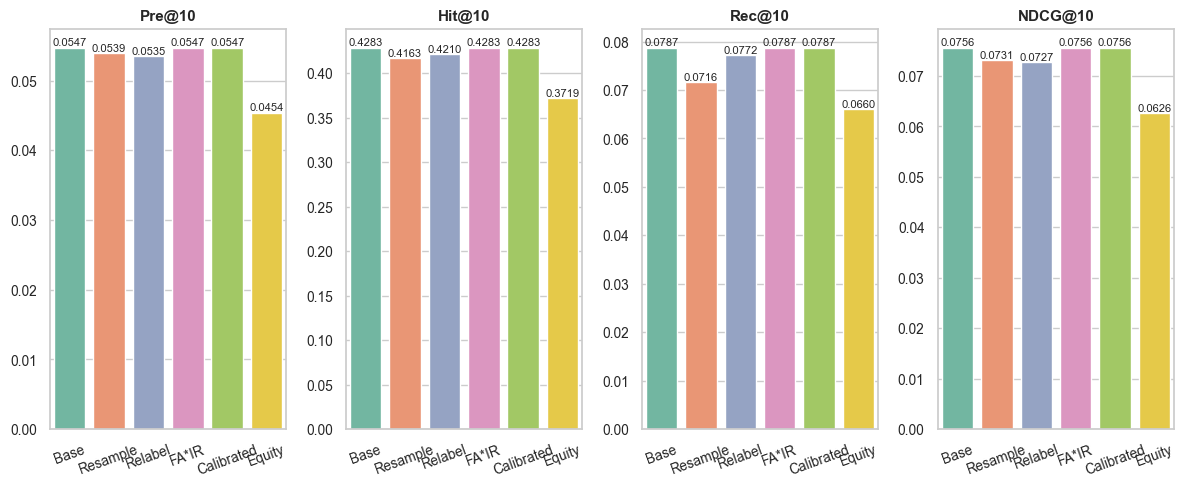

In [228]:
plot_metrics_row(df_results, acc_metrics, ncols=4)

/var/folders/p0/kj1_x6qd4_g0l4jk1pph8t840000gn/T/ipykernel_76069/2084228366.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/p0/kj1_x6qd4_g0l4jk1pph8t840000gn/T/ipykernel_76069/2084228366.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/p0/kj1_x6qd4_g0l4jk1pph8t840000gn/T/ipykernel_76069/2084228366.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/p0/kj1_x6qd4_g0l4jk1pph8t840000gn/T/ipykernel_76069/2084228366.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign 

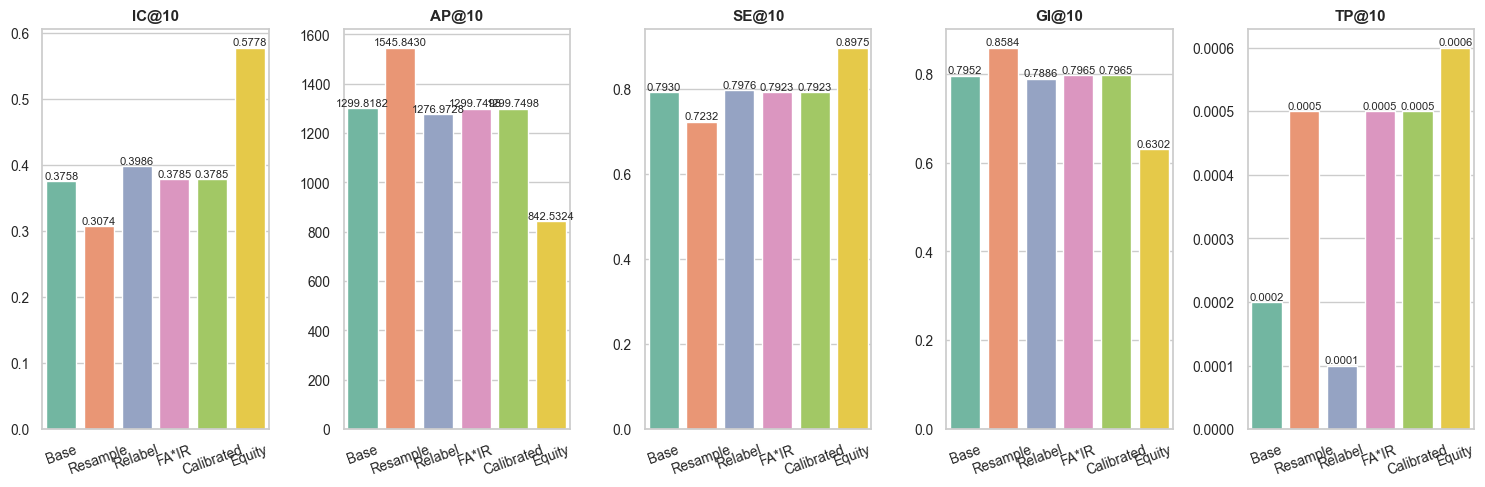

In [229]:
plot_metrics_row(df_results, fair_metrics, ncols=5)

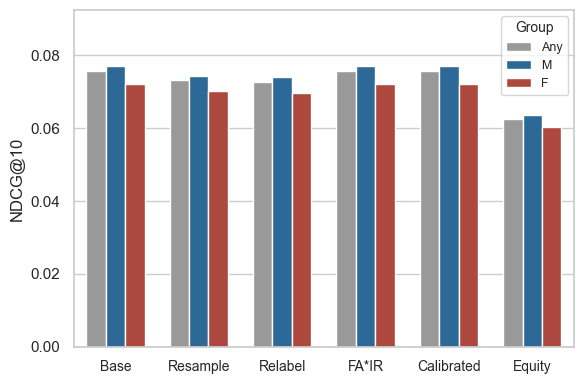

<Figure size 640x480 with 0 Axes>

In [230]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# === Prepare Plot Data ===
methods = df_results["Method"].tolist()
ndcg_all = df_results["NDCG@10"].tolist()
ndcg_male = df_results["NDCG@10(M)"].tolist()
ndcg_female = df_results["NDCG@10(F)"].tolist()

plot_data = []
for method, a, m, f in zip(methods, ndcg_all, ndcg_male, ndcg_female):
    plot_data.append({'Method': method, 'Group': 'Any', 'NDCG': a})
    plot_data.append({'Method': method, 'Group': 'M', 'NDCG': m})
    plot_data.append({'Method': method, 'Group': 'F', 'NDCG': f})

df_plot = pd.DataFrame(plot_data)

# === Plotting ===
sns.set_theme(style="whitegrid")
plt.figure(figsize=(len(methods) * 1, 4), facecolor="white")

ax = sns.barplot(
    data=df_plot,
    x='Method', y='NDCG', hue='Group',
    palette={'Any': '#999999', 'M': '#1b6ca8', 'F': '#c0392b'},  # Gray, Blue, Red
    width=0.7
)

# === Customize appearance ===
# Axis & labels
ax.set_ylabel("NDCG@10", fontsize=12)
ax.set_xlabel("")
ax.set_ylim(0, df_plot['NDCG'].max() * 1.2)  # Set y-axis limit to 120% of max NDCG
ax.tick_params(axis='x', labelsize=10)

# === Add legend ===
legend = ax.legend(title="Group", fontsize=9, title_fontsize=10)
#legend.set_frame_on(False)  # optional: remove box frame

# === Tight layout ===
plt.tight_layout()
plt.show()
plt.savefig("../docs/pictures/ndcg_group_plot.png", dpi=300, bbox_inches='tight', facecolor='white')

In [231]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_ndcg_by_group(df_results, metric_prefix="NDCG@10", save_path=None):
    # 构建 DataFrame 格式：Method, Group, Value
    methods = df_results["Method"].tolist()
    values_any = df_results[f"{metric_prefix}"].tolist()
    values_male = df_results[f"{metric_prefix}(M)"].tolist()
    values_female = df_results[f"{metric_prefix}(F)"].tolist()

    plot_data = []
    for method, a, m, f in zip(methods, values_any, values_male, values_female):
        plot_data.append({'Method': method, 'Group': 'Any', 'Value': a})
        plot_data.append({'Method': method, 'Group': 'M', 'Value': m})
        plot_data.append({'Method': method, 'Group': 'F', 'Value': f})

    df_plot = pd.DataFrame(plot_data)

    # Plot
    sns.set(style="whitegrid", font_scale=1.1)
    plt.figure(figsize=(6, 5))
    ax = sns.barplot(data=df_plot, x="Method", y="Value", hue="Group", palette=["gray", "steelblue", "firebrick"])

    plt.ylabel(f"{metric_prefix}")
    plt.ylim(0, df_plot['Value'].max() * 1.2)
    plt.title(f"{metric_prefix} by Gender Group", fontsize=13)
    plt.xticks(rotation=20)
    plt.legend(title="Group", fontsize=10, title_fontsize=11, loc='upper right')

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.tight_layout()
    plt.show()

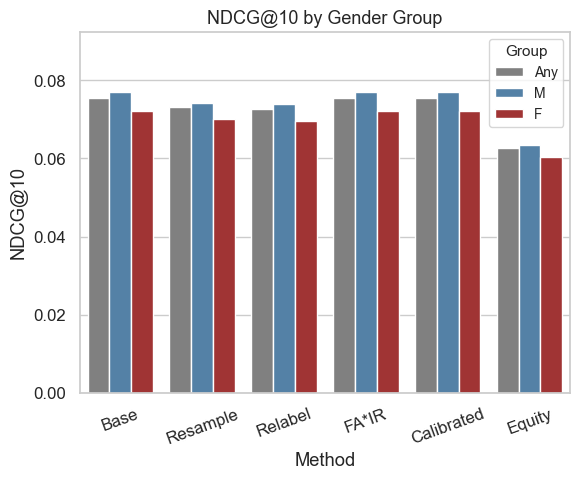

In [232]:
plot_ndcg_by_group(df_results, metric_prefix="NDCG@10")